# Spam detection in SMS data

***(Model Definition, Training, and Evaluation Notebook)***

## 6. Model Definition, Training, and Evaluation

### 6.1. Choice of Model

In our case study, we would like to predict whether the SMS text messages are spam or ham. Therefore, our problem can be cast into designing a Binary Classification model.

#### 6.1.1 Choice of Machine Learning Algorithm

Due to the concept of our problem, which is constructing a Binary Classification model, we need to apply some Supervised Machine Learning Algorithms that would be appropriate for our dataset for predicting spam and ham SMS messages. 

The supervised machine learning algorithms that we choose to proceed with are

1. Logistic Regression Classifier
2. Naive Bayes Classifier
3. Random Forest Classifier

#### 6.1.2 Choice of Deep Learning Algorithm

When it comes to Deep learning, there exist several algorithms that we can choose from. In this project, we would like to use a **Feed Forward Neural Network/Multi-Layer Perceptron** for our model. 

### Load Processed and Featured Engineered Data from IBM Cloud Object Storage

Let's begin with loading the data from the IBM Cloud object Storage into this notebook for further processing. Now we will to connect to the object store and read a PARQUET file and create a dataframe out of it.

In [1]:
import ibmos2spark, os
# @hidden_cell
credentials = {
    'endpoint': '********',
    'service_id': '********',
    'iam_service_endpoint': '********',
    'api_key': '********'
}

configuration_name = '********'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sdf_transformed = spark.read.parquet(cos.url('SMSSpamData_Transformed.parquet', 'advanceddatasciencecapstoneibm-donotdelete-pr-prnii9jvlql3tf'))
sdf_transformed.createOrReplaceTempView('sdf_transformed')
sdf_transformed.show(10)

+--------------------+--------+
|            features|bi_label|
+--------------------+--------+
|(3001,[0,161,170,...|     1.0|
|(3001,[0,331,564,...|     1.0|
|(3001,[0,44,147,2...|     1.0|
|(3001,[0,147,217,...|     1.0|
|(3001,[0,14,98,10...|     1.0|
|(3001,[0,214,215,...|     1.0|
|(3001,[0,17,452,1...|     1.0|
|(3001,[0,373,469,...|     1.0|
|(3001,[0,100,432,...|     1.0|
|(3001,[0,26,100,1...|     1.0|
+--------------------+--------+
only showing top 10 rows



In [2]:
# import required packages and libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

# Machine Learning with SparkML
import pyspark.sql.functions as fn
from pyspark.sql.types import FloatType
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Deep Learning with Keras
import keras
from keras.layers import Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
import sklearn
from sklearn import metrics

## 6.2 Data Spliting 

we split the data into training and test datasets - 80% training data and 20% test data.

In [3]:
df_train, df_test= sdf_transformed.randomSplit([0.8, 0.2], seed=10)

Now, let's check how the class label is split between the training and test data sets.

In [4]:
df_train.createOrReplaceTempView('df_train')
spark.sql("select bi_label, count(*) as train_data from df_train group by bi_label").show()

+--------+----------+
|bi_label|train_data|
+--------+----------+
|     0.0|       606|
|     1.0|       577|
+--------+----------+



In [5]:
df_test.createOrReplaceTempView('df_test')
spark.sql("select bi_label, count(*) as test_data from df_test group by bi_label").show()

+--------+---------+
|bi_label|test_data|
+--------+---------+
|     0.0|      141|
|     1.0|      170|
+--------+---------+



## 6.3 Model Definition

### 6.3.1 Machine Learning Models

Below, we define our three machine learning models, which are **model_nb**, **model_lr**, and **model_rf** represention **Naive Bayes model**, **Logistic Regression model**, and **Random Forest model**, respectively.

In [6]:
# Naive Bayes ML 
nb = NaiveBayes(featuresCol='features', labelCol='bi_label', predictionCol='prediction', probabilityCol='probability', rawPredictionCol='rawPrediction', smoothing=1)
model_nb = nb.fit(df_train)

In [7]:
# Logistic Regression
log_reg = LogisticRegression(featuresCol='features', labelCol='bi_label').setMaxIter(10).setRegParam(0.3).setElasticNetParam(0.8)
model_lr = log_reg.fit(df_train)

In [8]:
rf = RandomForestClassifier().setLabelCol('bi_label').setFeaturesCol('features').setNumTrees(10)
model_rf = rf.fit(df_train)

### 6.3.1 Deep Learning Model

Our training and testing data are represented as dataframes. To construct our deep learning model, we would like to use **Keras**. 

#### 6.3.1.1 Further Data Preparation

The Feed Forward Neural Network model accepts the input and output dataset as arrays. So, first we need to construct input and output data arrays from our training and test datasets. Therefore, we define the following function, i.e., **construct_arrays**, whose input is a dataframe and returns Feature array and Label array. 

In [9]:
def construct_arrays (df):
    # Initialize Input and Output arrays for the Data set
    X = []
    y = []
    
    # Convert dataframe from Spark DF to Pandas DF
    df_pd = df.toPandas()

    # Loop through dataframe and add data to input and output arrays
    for index, row in df_pd.iterrows():
        X.append(row[0])
        y.append(row[1])

    # Convery input and output data arrays from Python arrays to Numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return (X, y)

Passing the training and test data frames to the above function, we can obtain the respective input and output arrays containing the feature set and the label data.

In [10]:
X_train, y_train = construct_arrays(df_train)
print("Size of Training Features dataset: ", len(X_train))
print("Size of Training Label dataset: ", len(y_train))

X_test, y_test = construct_arrays (df_test)
print("Size of Test Features dataset: ", len(X_test))
print("Size of Test Label dataset: ", len(y_test))

Size of Training Features dataset:  1183
Size of Training Label dataset:  1183
Size of Test Features dataset:  311
Size of Test Label dataset:  311


#### 6.3.1.2 Deep Learning Model Construction

Now, we can define our Deep Learning Model using the Feed Forward Neural Network (Multilayer Perceptron) Algorithm. This model has 1 input, 1 hidden, and 1 output layers. 

We used 'binary_crossentropy' as a loss function because of binary output. We used 'adam' as an optimiser which makes use of momentum to avoid local minima and 'accuracy' as a measure of model performance.

In [11]:
model_dp=Sequential()
model_dp.add(Dense(512, activation='relu', input_shape=(3001,)))
model_dp.add(Dropout(0.5))
model_dp.add(Dense(256, activation='relu'))
model_dp.add(Dropout(0.5))
model_dp.add(Dense(1, activation='sigmoid'))
model_dp.summary()
model_dp.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc',keras.metrics.binary_accuracy])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1537024   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,668,609
Trainable params: 1,668,609
Non-trainable params: 0
_________________________________________________________________


2022-03-15 05:50:21.418817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model_save_path="smsspam_detector_model.h5"

In [13]:
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=2,
                               save_best_only=True)    


# define tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [14]:
history=model_dp.fit(X_train,y_train,batch_size=64,
         epochs=10, verbose=1,
         shuffle=True,
         validation_data=(X_test,y_test),
         callbacks=[checkpointer, tensorboard])

Epoch 1/10
17/19 [=========================>....] - ETA: 0s - loss: 1.2427 - acc: 0.5358 - binary_accuracy: 0.5358
Epoch 00001: val_loss improved from inf to 0.55626, saving model to smsspam_detector_model.h5
19/19 [==============================] - 2s 55ms/step - loss: 1.2274 - acc: 0.5402 - binary_accuracy: 0.5402 - val_loss: 0.5563 - val_acc: 0.7717 - val_binary_accuracy: 0.7717
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 0.6373 - acc: 0.7160 - binary_accuracy: 0.7160
Epoch 00002: val_loss improved from 0.55626 to 0.36134, saving model to smsspam_detector_model.h5
19/19 [==============================] - 1s 40ms/step - loss: 0.6373 - acc: 0.7160 - binary_accuracy: 0.7160 - val_loss: 0.3613 - val_acc: 0.8714 - val_binary_accuracy: 0.8714
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.2808 - acc: 0.9062 - binary_accuracy: 0.9062
Epoch 00003: val_loss improved from 0.36134 to 0.23050, saving model to smsspam_detector_model.h5
19/19 [======

Let's have a quick look at the five last loss and accuracy values for training and valication steps.

In [15]:
metrics_dp = pd.DataFrame(history.history).drop(["binary_accuracy","val_binary_accuracy"], axis=1)
metrics_dp.rename(columns = {'loss': 'Training_Loss', 'acc': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_acc': 'Validation_Accuracy'}, inplace = True)
metrics_dp[:-5]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,1.227408,0.540152,0.556259,0.771704
1,0.637346,0.715976,0.361335,0.871383
2,0.280811,0.906171,0.230501,0.932476
3,0.148462,0.954353,0.174565,0.954984
4,0.077803,0.983094,0.172149,0.961415


To plot some results for our deep learning model, we define a function, i.e., **plot_graph**.

In [16]:
def plot_graph(var1, var2, string):
    metrics_dp[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

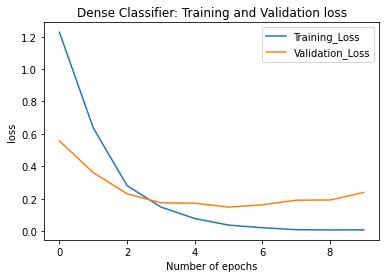

In [17]:
plot_graph('Training_Loss', 'Validation_Loss', 'loss')

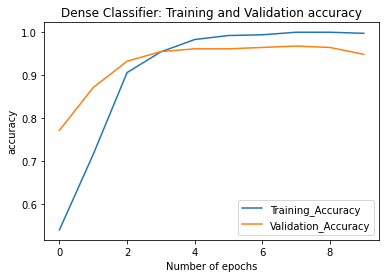

In [18]:
plot_graph('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## 6.4 Model Evaluation

Below we define three functions as

1. **predict** function for our deep learning model.


2. **getResults** function to compute the results from our Machine Learning and Deep Learning models. The metrics to produce the results inculde *area under ROC*, *precision*, *recall*, and *f1 score*. Furthermore, we extract *True Positive (TP)*, *True Negative (TN)*, *False Positive (FP)*, and *False Negative (FN)*, which are later used to construct the *Confusion Matrix*.


3. **heatmap_plot** function to plot the *Confusion Matrix*.

In [19]:
model_dict={}
model_dict['Naive_Bayes']=model_nb
model_dict['Logistic_Regression']=model_lr
model_dict['Random_Forest']=model_rf
model_dict['Deep_Learning']=model_dp

def predict(data):
    result=model_dp.predict(data)
    prediction = [np.round(x[0]) for x in result]
    return prediction


def getResults(model_dict,sample_test,sample_x,sample_y):
    '''
    Get results from different models
    '''
    results=[]
    
    results_cm={}
    
    for name,model in model_dict.items(): 
        
        if name in 'Deep_Learning':
            sample_predicted = predict(sample_x)
            cm = sklearn.metrics.confusion_matrix(sample_y, sample_predicted)
            auroc = sklearn.metrics.roc_auc_score(sample_y, sample_predicted)
            res=sklearn.metrics.precision_recall_fscore_support(sample_y, sample_predicted)
            f1_score = np.mean(res[2])
            precision = np.mean(res[0])
            recall = np.mean(res[1])
        else:
            sample_predicted = model.transform(sample_test)
            preds_and_labels = sample_predicted.select(['prediction','bi_label'])\
            .withColumn('label_new', fn.col('bi_label').cast(FloatType())).orderBy('prediction')
            preds_and_labels = preds_and_labels.select(['prediction','label_new'])
            metrics_bi = BinaryClassificationMetrics(preds_and_labels.rdd.map(tuple))
            metrics_mu = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
            cm=metrics_mu.confusionMatrix().toArray().astype(int)
            auroc = metrics_bi.areaUnderROC
            f1_score = metrics_mu.fMeasure(1.0)
            precision = metrics_mu.precision(1.0)
            recall = metrics_mu.recall(1.0)
            
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        results_cm[name]=cm
        total= sample_test.count()

        
        results.append([name, auroc, precision, recall, f1_score,total,TP, FP,FN,TN]) 
    
        df_cols=['model','area_under_ROC','precision','recall','f1_score', 'total_test_sample','TP','FP','FN','TN']
        result_df=pd.DataFrame(results,columns=df_cols)
    return result_df, results_cm

def heatmap_plot(cm,title):
    df_cm = pd.DataFrame(cm, index = ['ham', 'spam'])
    df_cm.columns=['ham','spam']

    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()
    return

In [20]:
result, results_cm=getResults(model_dict,df_test,X_test,y_test)
result

,model,area_under_ROC,precision,recall,f1_score,total_test_sample,TP,FP,FN,TN
0,Naive_Bayes,0.907363,0.903409,0.935294,0.919075,311,124,17,11,159
1,Logistic_Regression,0.644556,0.869565,0.352941,0.502092,311,132,9,110,60
2,Random_Forest,0.847580,0.968504,0.723529,0.828283,311,137,4,47,123
3,Deep_Learning,0.951731,0.947919,0.951731,0.948399,311,139,2,14,156


The above table shows that the *Naive Bayes Classifier* has better performance among the other Machine Learning models that we employed in this project. Furthermore, our Deep Learning model performs better than our machine learning models.

#### Confusion Matrices for our ML and DL models

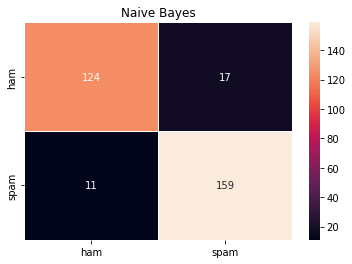

In [21]:
heatmap_plot(results_cm['Naive_Bayes'],'Naive Bayes')

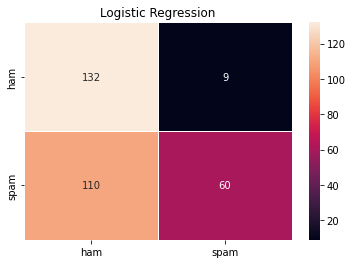

In [22]:
heatmap_plot(results_cm['Logistic_Regression'],'Logistic Regression')

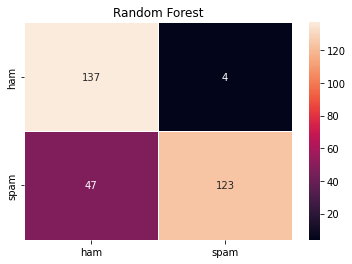

In [23]:
heatmap_plot(results_cm['Random_Forest'],'Random Forest')

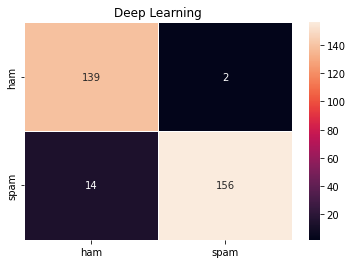

In [24]:
heatmap_plot(results_cm['Deep_Learning'],'Deep Learning')